# Pose distributions remain the same after transformation

In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from toolz import compose, valmap, groupby, partial
from toolz.curried import get_in, pluck
from itertools import combinations
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist
from sklearn.preprocessing import StandardScaler
from aging.plotting import format_plots, PlotConfig, save_factory, figure, ONTOGENY_AGE_CMAP, legend
import warnings
warnings.simplefilter('ignore')

from scipy.stats import wasserstein_distance

import jax
import jax.numpy as jnp

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "size-normalization", tight_layout=False)

In [3]:
# use jax to run pca because it can be run on the gpu
def svd_sign_flip(u, v):
    # taken from: https://github.com/scikit-learn/scikit-learn/blob/2a2772a87b6c772dc3b8292bcffb990ce27515a8/sklearn/utils/extmath.py#L766
    max_abs_cols = jnp.argmax(jnp.abs(u), axis=0)
    signs = jnp.sign(u[max_abs_cols, jnp.arange(u.shape[1])])
    return v * signs[:, None]


@partial(jax.jit, static_argnums=(1, 2))
def jax_pca(x, n_dims=10, subsample=2):
    # subsample to allow this to run on the GPU
    mu = jnp.mean(x, axis=0)
    x = x - mu
    U, s, Vt = jnp.linalg.svd(x[::subsample], full_matrices=False)
    Vt = svd_sign_flip(U, Vt)
    # ref: https://www.sjsu.edu/faculty/guangliang.chen/Math253S20/lec5svd.pdf
    # and sklearn's PCA
    return mu, Vt.T, x @ Vt.T[:, :n_dims]


def load():
    tmp = joblib.load("/n/scratch3/users/w/wg41/aging-aligned-frames.p")
    # group the two datasets by age
    age_grouped = valmap(
        compose(list, pluck(1)),
        groupby(get_in([0, -1]), tmp["frames"].items()),
    )

    age_grouped_recon = valmap(
        compose(list, pluck(1)),
        groupby(get_in([0, -1]), tmp["recon"].items()),
    )
    return age_grouped, age_grouped_recon


def zscore(arr):
    if isinstance(arr, dict):
        total = flatten(np.concatenate(list(arr.values()), axis=0))
        mu = np.nanmean(total, axis=0)
        std = np.nanstd(total, axis=0)
        return valmap(lambda v: (v - mu) / std, arr)
    elif isinstance(arr, list):
        total = flatten(np.concatenate(arr, axis=0))
        mu = np.nanmean(total, axis=0)
        std = np.nanstd(total, axis=0)
        return list(map(lambda v: (v - mu) / std, arr))

    return (arr - np.nanmean(arr, axis=0, keepdims=True)) / np.nanstd(
        arr, axis=0, keepdims=True
    )


def flatten(x):
    return x.reshape(len(x), -1)


def run_pca(arr):
    print("Running")
    mu, V, pcs = jax_pca(jnp.array(flatten(np.concatenate(arr, axis=0))), subsample=5)
    return zscore(list(map(lambda v: (flatten(v) - mu) @ V[:, :10], arr)))

In [4]:
run_pca_flag = True
if run_pca_flag:
    age_grouped, age_grouped_recon = load()
    age_grouped_pca = valmap(run_pca, age_grouped)
    age_grouped_recon_pca = valmap(run_pca, age_grouped_recon)
    joblib.dump(
        dict(frame_pcs=age_grouped_pca, recon_pcs=age_grouped_recon_pca),
        "/n/scratch3/users/w/wg41/age-grouped-frames-pca.p",
    )
else:
    data = joblib.load("/n/scratch3/users/w/wg41/age-grouped-frames-pca.p")
    age_grouped_pca = data["frame_pcs"]
    age_grouped_recon_pca = data["recon_pcs"]

Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running
Running


In [8]:
within_dist = {}
for k, v in age_grouped_pca.items():
    dists = [wasserstein_distance(a[:, 0], b[:, 0]) for a, b in combinations(v, 2)]
    within_dist[k] = dists

In [10]:
within_dist_recon = {}
for k, v in age_grouped_recon_pca.items():
    dists = [wasserstein_distance(a[:, 0], b[:, 0]) for a, b in combinations(v, 2)]
    within_dist_recon[k] = dists

In [23]:
between_snn = {}
for k, v in age_grouped_recon_pca.items():
    dists = [wasserstein_distance(a[:, 0], b[:, 0]) for a, b in zip(v, age_grouped_pca[k])]
    between_snn[k] = dists

In [12]:
np.concatenate(list(within_dist.values())).mean()

0.31869298553955433

In [13]:
np.concatenate(list(within_dist_recon.values())).mean()

0.2003410605664668

In [24]:
wd_df = []
for k, v in within_dist.items():
    wd_df.append(pd.DataFrame(dict(age=k, dist=v, frame='Original')))
    wd_df.append(pd.DataFrame(dict(age=k, dist=within_dist_recon[k], frame='Transformed')))
    wd_df.append(pd.DataFrame(dict(age=k, dist=between_snn[k], frame='Between')))
wd_df = pd.concat(wd_df, ignore_index=True)

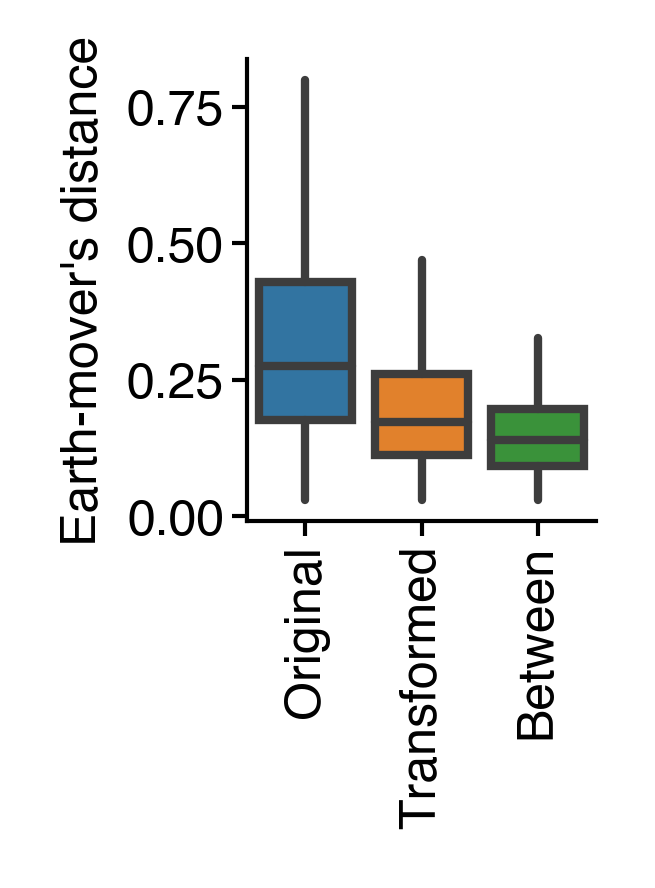

In [31]:
fig = figure(0.75, 1)
ax = sns.boxplot(
    data=wd_df, x="frame", y="dist", showcaps=False, showfliers=False, linewidth=1
)
ax.set(ylabel="Earth-mover's distance", xlabel="")
sns.despine()
plt.xticks(rotation=90)
saver(fig, "pose-pca-distribution-within-vs-between-transformation-boxplot");

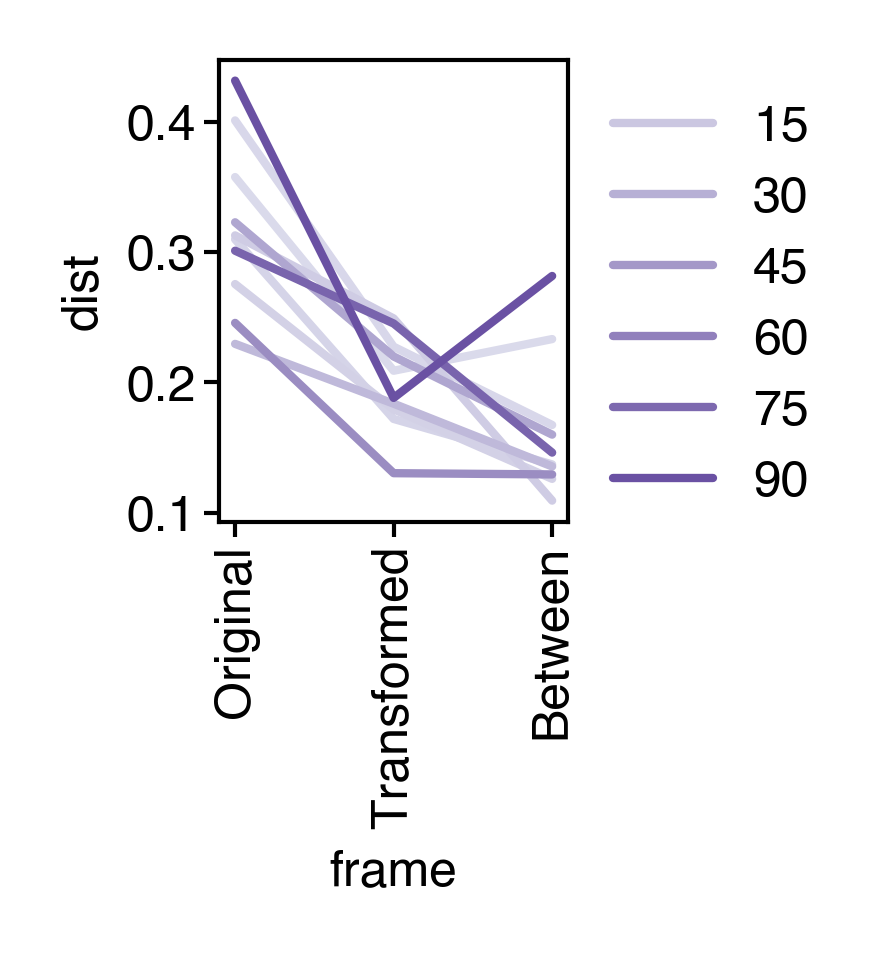

In [34]:
fig = figure(0.75, 1)
ax = sns.lineplot(data=wd_df, x='frame', y='dist', hue='age', palette=ONTOGENY_AGE_CMAP, errorbar=None)
plt.xticks(rotation=90)
legend(ax)

## TODO: show some examples

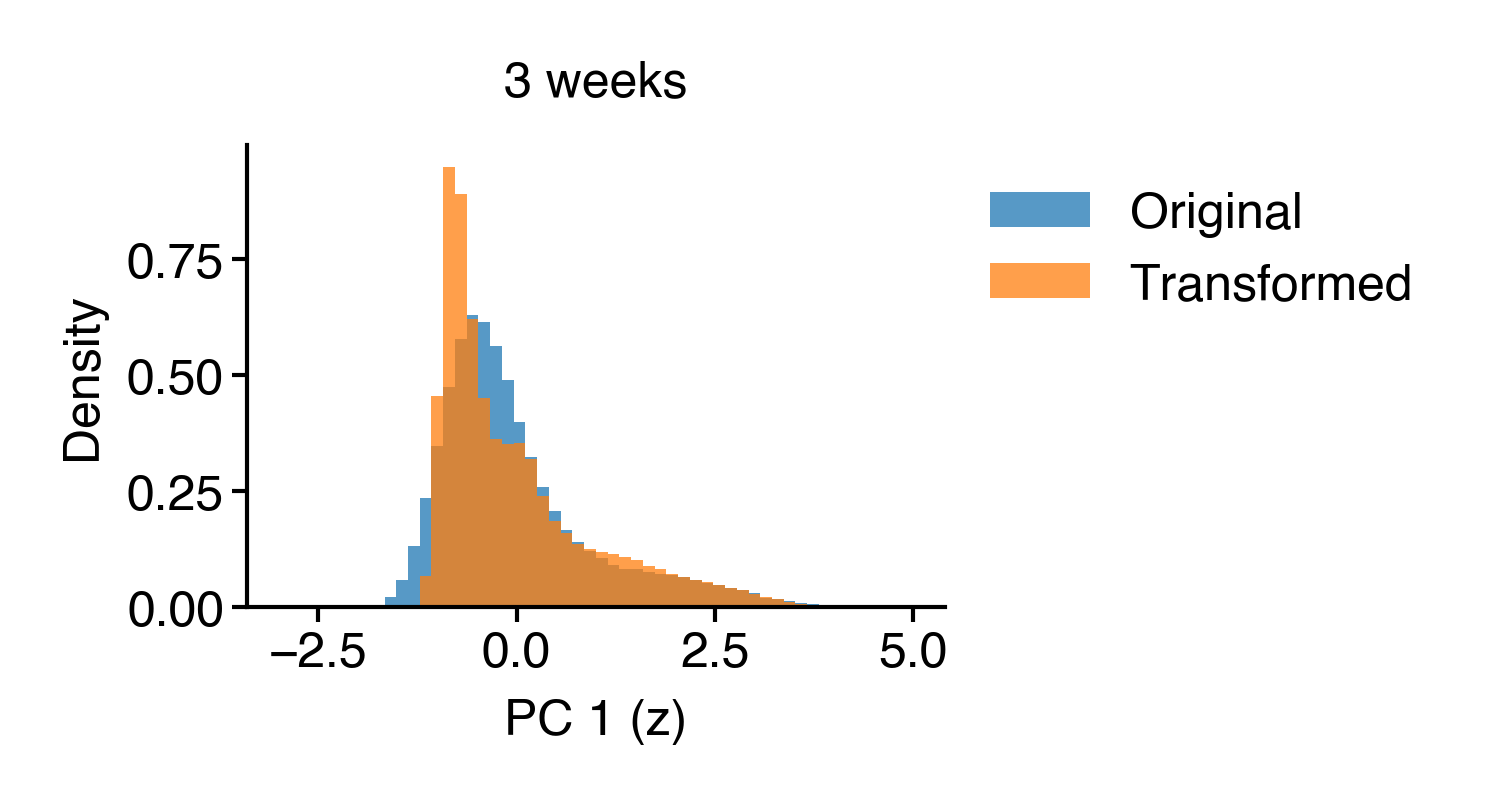

In [12]:
n_bins = np.linspace(-3, 5, 55)
fig = figure(1.5, 1)
sns.histplot(
    age_grouped_pca[3][:, 0],
    bins=n_bins,
    element="step",
    stat="density",
    lw=0,
    label="Original",
)
ax = sns.histplot(
    age_grouped_recon_pca[3][:, 0],
    bins=n_bins,
    element="step",
    stat="density",
    lw=0,
    label="Transformed",
)
ax.set(title="3 weeks", xlabel="PC 1 (z)")
legend(ax)
sns.despine()
saver(fig, "pose-pca-distribution-comparison-3-weeks");

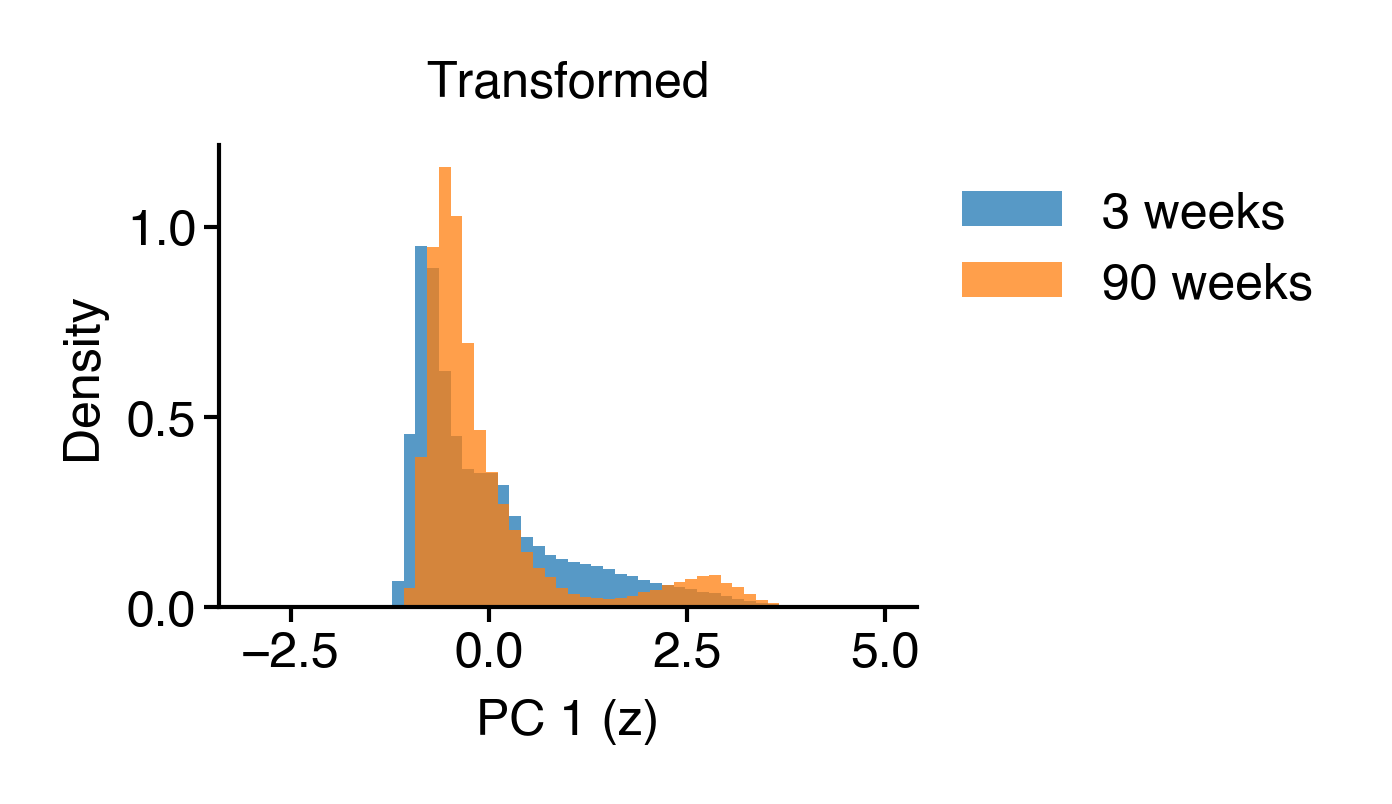

In [13]:
n_bins = np.linspace(-3, 5, 55)
fig = figure(1.5, 1)
sns.histplot(
    age_grouped_recon_pca[3][:, 0],
    bins=n_bins,
    element="step",
    stat="density",
    lw=0,
    label="3 weeks",
)
ax = sns.histplot(
    age_grouped_recon_pca[90][:, 0],
    bins=n_bins,
    element="step",
    stat="density",
    lw=0,
    label="90 weeks",
)
ax.set(title="Transformed", xlabel="PC 1 (z)")
legend(ax)
sns.despine()
saver(fig, "pose-pca-distribution-transformed-3-weeks-90-weeks");

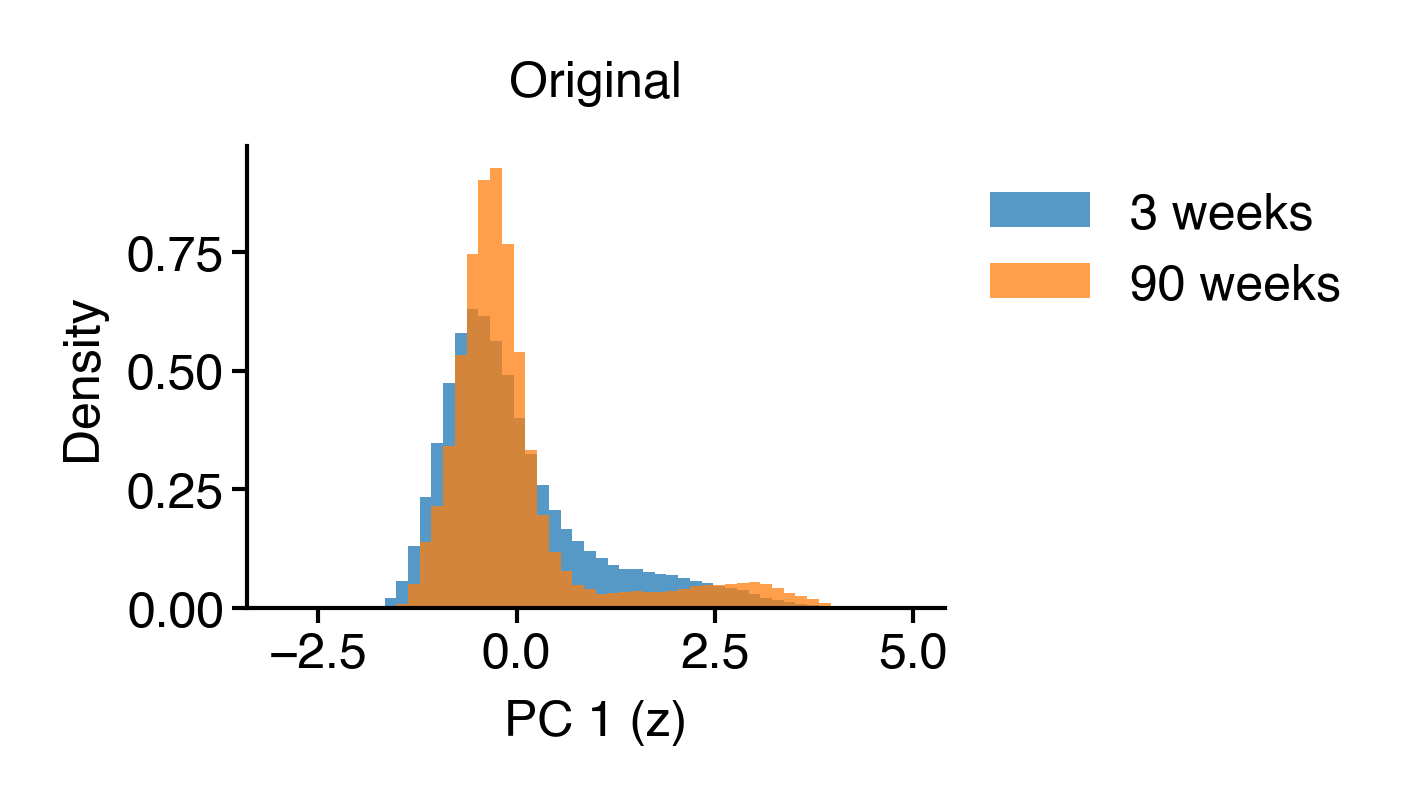

In [14]:
n_bins = np.linspace(-3, 5, 55)
fig = figure(1.5, 1)
sns.histplot(
    age_grouped_pca[3][:, 0],
    bins=n_bins,
    element="step",
    stat="density",
    lw=0,
    label="3 weeks",
)
ax = sns.histplot(
    age_grouped_pca[90][:, 0],
    bins=n_bins,
    element="step",
    stat="density",
    lw=0,
    label="90 weeks",
)
ax.set(title="Original", xlabel="PC 1 (z)")
legend(ax)
sns.despine()
saver(fig, "pose-pca-distribution-original-3-weeks-90-weeks");